### Look at Weights of Decoders
- Have 28 timebins, 20 decoders per step, 59 neurons, 4 classes per feature dimension
- Want to understand: At each timebin, which neurons are important for decoding feature? 
- Steps:
  1. Take absolute value of weights for each decoder
  2. Per timebin, average weights of each decoder
  3. For each neuron, take max weight across the 4 classes (when does neuron contribute the most)
  4. Optionally: can multiply in variance of each neuron across timebins, trials. 


In [2]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 
pre_interval = 1300
post_interval = 1500

feature_dims = ["Color", "Shape", "Pattern"]

In [3]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   

feature_selections = pd.read_pickle(fs.open("l2l.pqz317.scratch/feature_selections.pickle"))
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))

In [4]:
temp_units = spike_utils.get_temporal_drive_unit_ids(fs, subject, session)
ant_units = spike_utils.get_anterior_drive_unit_ids(fs, subject, session)

temp_then_ant = np.concatenate((temp_units, ant_units))


In [5]:
# get spike count variances per unit
unit_vars = spike_utils.get_variances_for_units(firing_rates)
spike_count_vars = unit_vars.SpikeCountVar
spike_count_vars = spike_count_vars[:, None]

/tmp/ipykernel_1384012/2132661813.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  spike_count_vars = spike_count_vars[:, None]


### Accounting for neuron firing variance across time bin, trials



(28,)
(28,)
(28,)


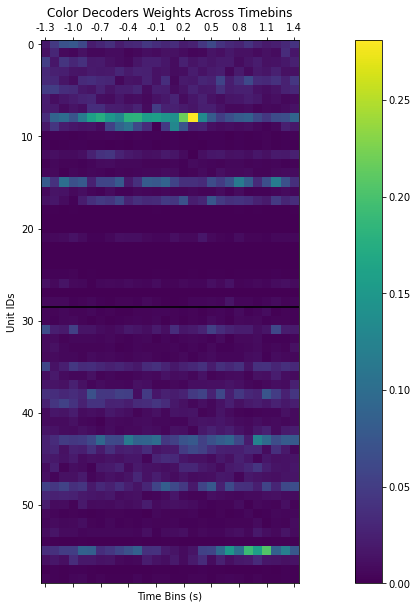

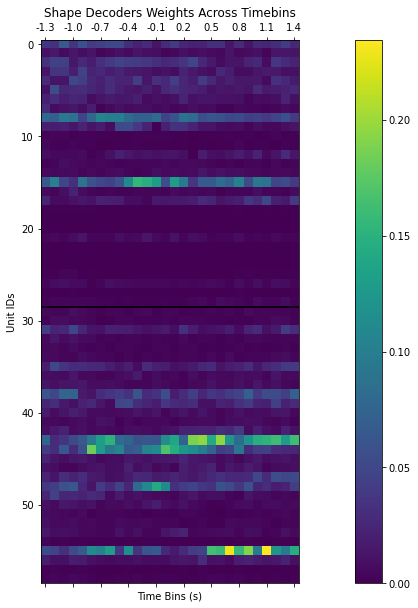

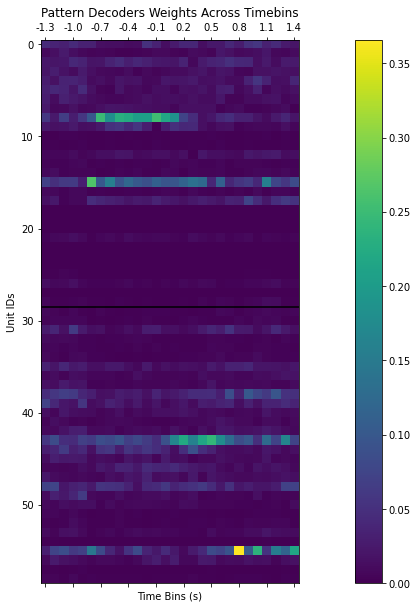

In [60]:
for feature_dim in feature_dims:
    # models are num_time_points x num_models
    models = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 4)
    weights = weights.T
    var_accounted = weights * spike_count_vars

    sums = np.sum(var_accounted, axis=0)
    print(sums.shape)

    normalized = var_accounted / np.sum(var_accounted, axis=0)
    # reorder by temp then ant
    reordered = normalized[temp_then_ant, :]

    fig, ax = plt.subplots(figsize=(20, 10))
    colors = ax.matshow(reordered)
    fig.colorbar(colors)
    axis = np.arange(0, 28, 3)
    labels = np.around((axis - 13) * 0.1, 1)
    ax.set_xticks(axis)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Time Bins (s)")
    ax.set_ylabel("Unit IDs")
    ax.axhline(len(temp_units) - 0.5, color='k')

    ax.set_title(f"{feature_dim} Decoders Weights Across Timebins")    




### Not Accounting for Neuron Variance

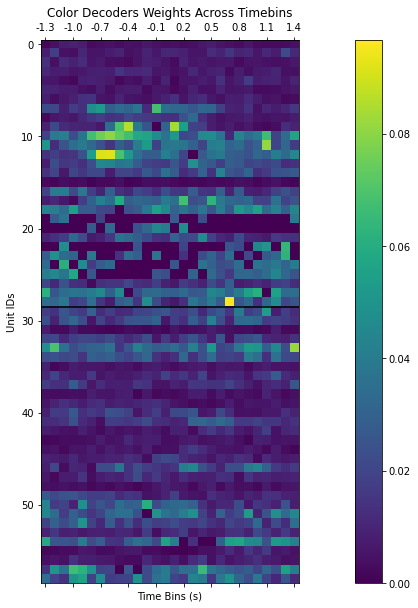

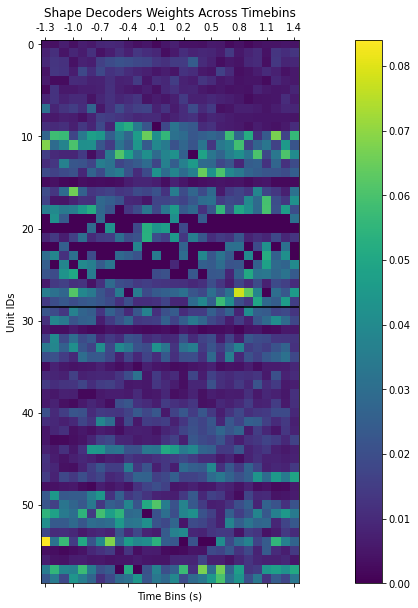

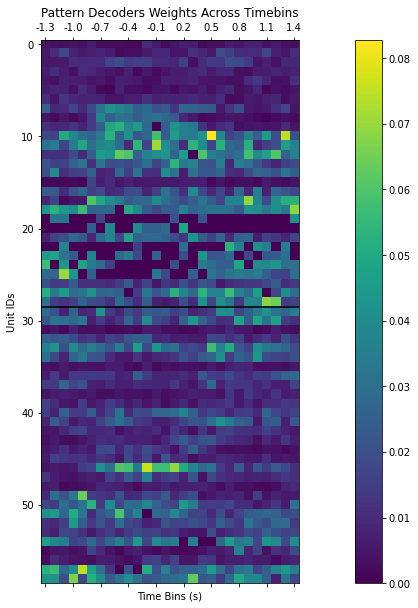

In [6]:
for feature_dim in feature_dims:
    # models are num_time_points x num_models
    models = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_lr_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"), allow_pickle=True)
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, 59, 4)
    weights = weights.T
    
    normalized = weights / np.sum(weights, axis=0)
    # reorder by temp then ant
    reordered = normalized[temp_then_ant, :]

    fig, ax = plt.subplots(figsize=(20, 10))
    colors = ax.matshow(reordered)
    fig.colorbar(colors)
    axis = np.arange(0, 28, 3)
    labels = np.around((axis - 13) * 0.1, 1)
    ax.set_xticks(axis)
    ax.set_xticklabels(labels)
    ax.set_xlabel("Time Bins (s)")
    ax.set_ylabel("Unit IDs")
    ax.axhline(len(temp_units) - 0.5, color='k')

    ax.set_title(f"{feature_dim} Decoders Weights Across Timebins")    


